<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/PSF_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install photutils --quiet

     |████████████████████████████████| 826 kB 7.8 MB/s 


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import photutils as phot
from photutils.aperture import aperture_photometry

from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
import scipy.optimize as opt
from astropy.convolution import convolve
from matplotlib import colors
from time import perf_counter
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting

matplotlib.rcParams['figure.figsize'] = (10,10)
matplotlib.rcParams['font.size']=10

In [5]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable

In [6]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 628, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (249/249), done.
remote: Total 628 (delta 139), reused 4 (delta 2), pack-reused 375
Receiving objects: 100% (628/628), 64.06 MiB | 22.56 MiB/s, done.
Resolving deltas: 100% (327/327), done.


In [7]:
cd INSIST/data

/content/INSIST/data


# **Convolutions**

In [8]:
fwhm_in     = 0.2 # arcsecs
pixel_scale = 0.01
FWHM        = fwhm_in/pixel_scale
sigma       = FWHM*gaussian_fwhm_to_sigma
sigma

8.493218002880191

## **Off-axis**

### **Using  PyTorch**

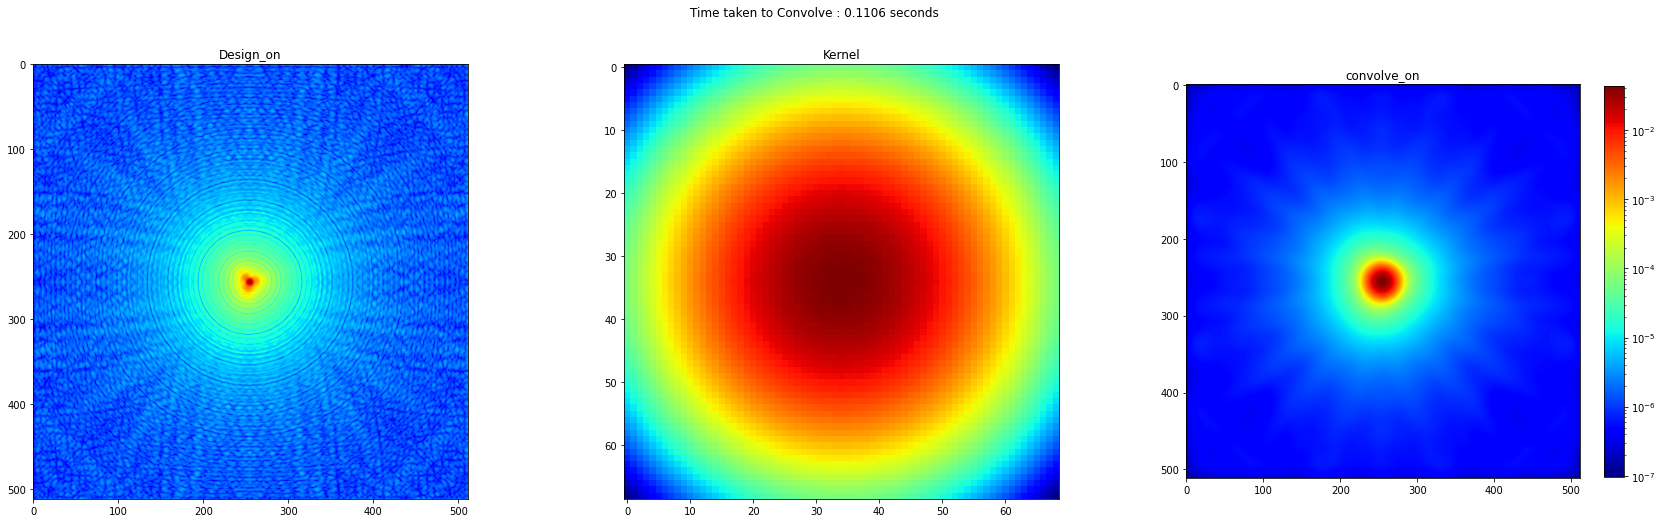

In [9]:
Off_PSF =np.loadtxt("off_axis.TXT",skiprows=18,encoding='latin-1') # Read PSF file
Off_PSF = (1*Off_PSF)/Off_PSF.max()

fig, ax = plt.subplots(1,3, figsize = (30,8))
ax[0].set_title("Design_on")
ax[0].imshow(Off_PSF, cmap="jet",norm=colors.LogNorm())

kernel = Gaussian2DKernel(sigma,sigma,x_size=69,y_size=69)
kernel.normalize()

Off_PSF_ = np.pad(Off_PSF,34,mode='constant')

data     = torch.tensor(Off_PSF_).unsqueeze(0).cuda()
kernel_t = torch.tensor(kernel.array).cuda()

start = perf_counter()
out = F.conv2d(Variable(data.view(1,1,580,580)),Variable(kernel_t.view(1,1,69,69))).squeeze().cpu().numpy()

stop  = perf_counter()- start

ax[1].set_title("Kernel")
ax[1].imshow(kernel, cmap="jet",norm=colors.LogNorm())

ax[2].set_title("convolve_on")
im_on = ax[2].imshow(out, cmap="jet",norm=colors.LogNorm())
plt.colorbar(im_on,shrink=0.9)
fig.suptitle(f"Time taken to Convolve : {np.round(stop,4)} seconds");

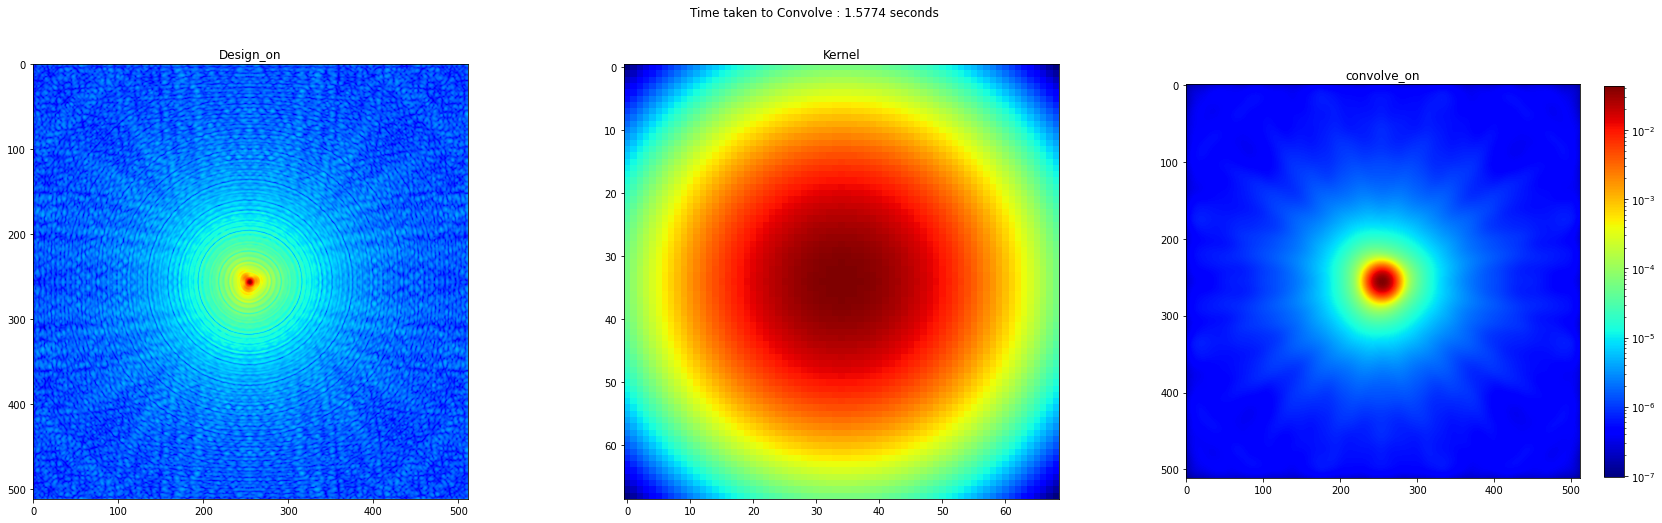

In [10]:
fig, ax = plt.subplots(1,3, figsize = (30,8))
ax[0].set_title("Design_on")
ax[0].imshow(Off_PSF, cmap="jet",norm=colors.LogNorm())
start = perf_counter()
astropy_conv_off = convolve(Off_PSF, kernel) 

stop  = perf_counter()- start

ax[1].set_title("Kernel")
ax[1].imshow(kernel, cmap="jet",norm=colors.LogNorm())

ax[2].set_title("convolve_on")
im_on = ax[2].imshow(astropy_conv_off, cmap="jet",norm=colors.LogNorm())
plt.colorbar(im_on,shrink=0.9)
fig.suptitle(f"Time taken to Convolve : {np.round(stop,4)} seconds");

FWHM calculation using pixel to pixel distance

In [40]:
def fwhm_pixel_dist(data,r_frac=0.01):
  flux_p  = data.max()
  i_p,j_p = np.where(data == flux_p)

  coords = []
  for i in range(data.shape[0]):
    for j in range(data.shape[0]):
      f = data[i,j]
      if f>= flux_p/2 and f<=flux_p/2+ flux_p/2*r_frac:
        break
    if f>=flux_p/2 and f<=flux_p/2+ flux_p/2*r_frac:
      coords.append([i,j,f])
  coords = np.array(coords)

  dist = np.sqrt( (i_p[0]- coords[:,0])**2 + (j_p[0]- coords[:,1])**2 )*2
  return coords , dist.mean()

In [41]:
coords, FWHM = fwhm_pixel_dist(astropy_conv_off)
FWHM

21.086042611302233

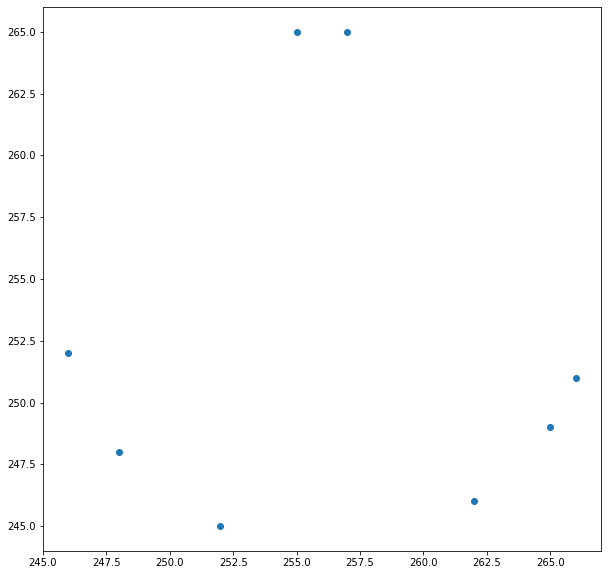

In [13]:
plt.scatter(coords[:,0], coords[:,1])

In [14]:
init = models.Gaussian2D()

fit  = fitting.LevMarLSQFitter()

y, x = np.mgrid[-256:256,-256:256]/256

model = fit(init,x,y,astropy_conv_off)
model

<Gaussian2D(amplitude=0.04347302, x_mean=-0.00549965, y_mean=0.00057359, x_stddev=0.03509108, y_stddev=0.03520674, theta=722.39958971)>

In [15]:
arr_scale = 2/512.0
arr_scale

0.00390625

In [17]:
sx = model.x_stddev.value/arr_scale
sy = model.y_stddev.value/arr_scale

In [18]:
print("FWHM_x        : {} \nFWHM_y        : {}\nPeak position : {}".format(sx*gaussian_sigma_to_fwhm, sy*gaussian_sigma_to_fwhm, np.where(astropy_conv_off==astropy_conv_off.max())))

FWHM_x        : 21.15409342683184 
FWHM_y        : 21.223815007130934
Peak position : (array([256]), array([255]))


Flux inside 3 sigma radius

In [50]:
positions  = [(256,255)]
aperture   = phot.aperture.CircularAperture(positions, r=sx*3)
data       = astropy_conv_off
phot_table = aperture_photometry(data, aperture)
phot_table['fraction'] = phot_table['aperture_sum']/data.sum()
phot
phot_table

id,xcenter,ycenter,aperture_sum,fraction
,pix,pix,,
int64,float64,float64,float64,float64
1,256.0,255.0,21.958466629007734,0.9490682019107902


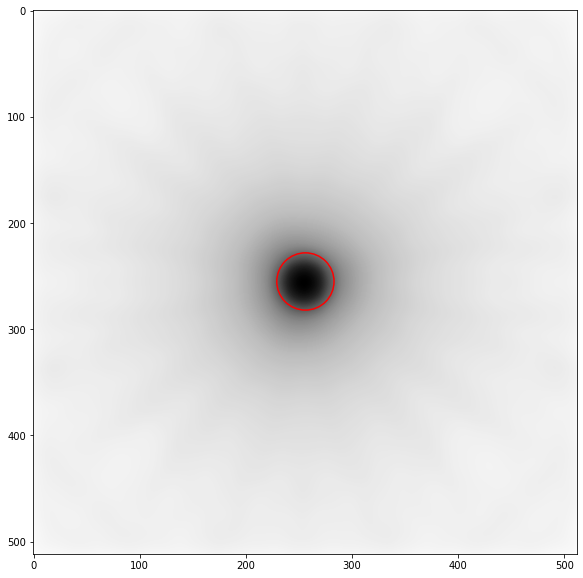

In [51]:
fig,ax = plt.subplots(1)
ax.imshow(data, cmap = 'Greys',norm=colors.LogNorm())
aperture.plot(axes=ax, color='red', lw=1.5)

## **On-axis**

### **Using PyTorch**

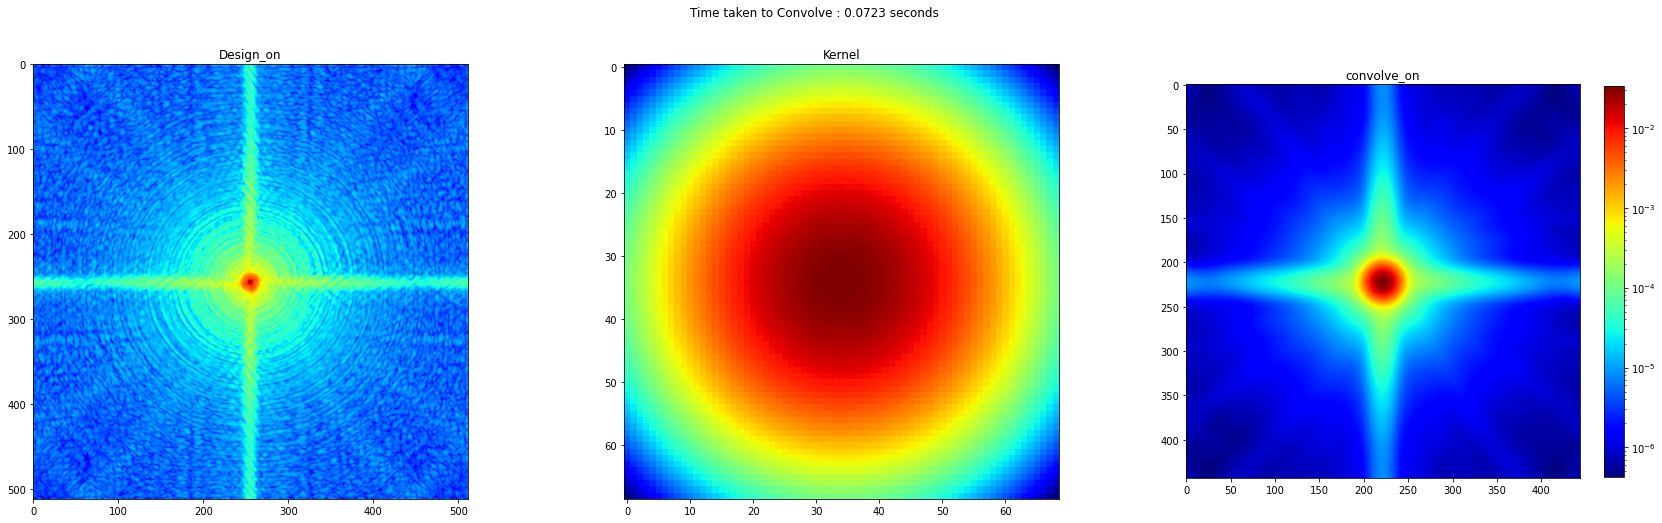

In [20]:
On_PSF = np.loadtxt("on_axis_nor.TXT") # Read PSF file
On_PSF = (0.75*On_PSF)/On_PSF.max()

fig, ax = plt.subplots(1,3, figsize = (30,8))
ax[0].set_title("Design_on")
ax[0].imshow(On_PSF, cmap="jet",norm=colors.LogNorm())

kernel = Gaussian2DKernel(sigma,sigma,x_size=69,y_size=69)
kernel.normalize()

data     = torch.tensor(On_PSF).unsqueeze(0).cuda()
kernel_t = torch.tensor(kernel.array).cuda()

start = perf_counter()
out = F.conv2d(Variable(data.view(1,1,512,512)),Variable(kernel_t.view(1,1,69,69))).squeeze().cpu().numpy()

stop  = perf_counter()- start

ax[1].set_title("Kernel")
ax[1].imshow(kernel, cmap="jet",norm=colors.LogNorm())

ax[2].set_title("convolve_on")
im_on = ax[2].imshow(out, cmap="jet",norm=colors.LogNorm())
plt.colorbar(im_on,shrink=0.9)
fig.suptitle(f"Time taken to Convolve : {np.round(stop,4)} seconds");

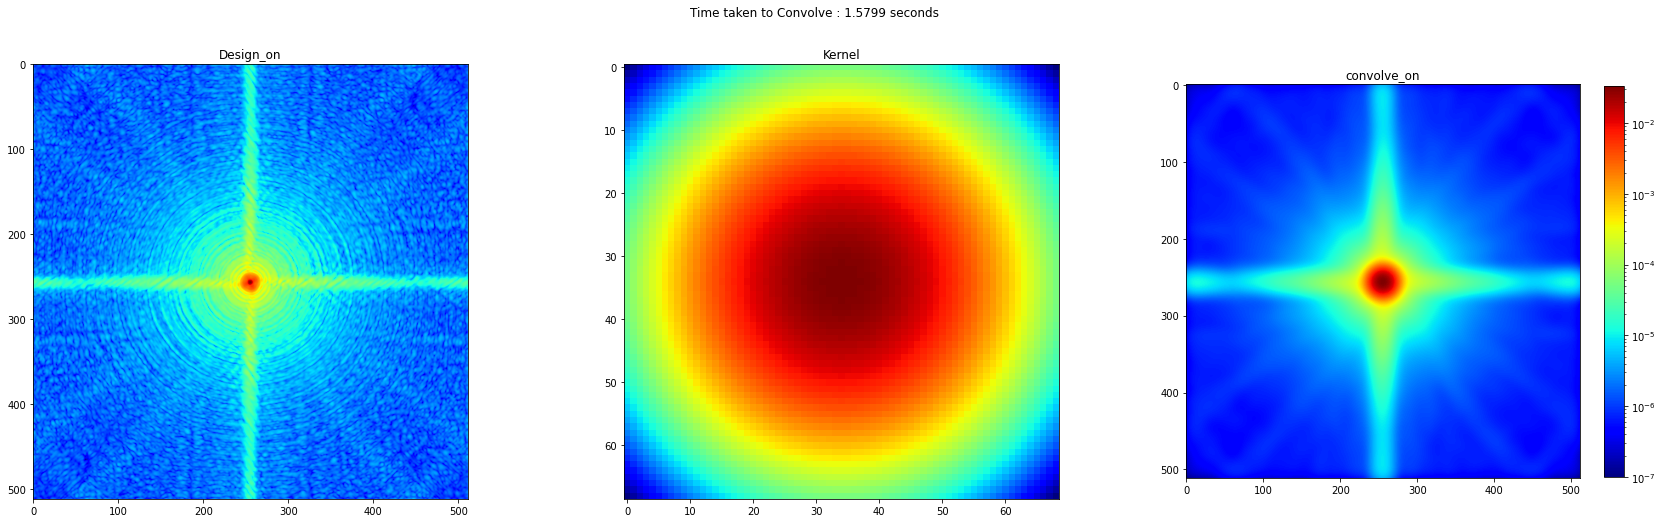

In [21]:
On_PSF = np.loadtxt("on_axis_nor.TXT") # Read PSF file
On_PSF = (0.75*On_PSF)/On_PSF.max()

fig, ax = plt.subplots(1,3, figsize = (30,8))
ax[0].set_title("Design_on")
ax[0].imshow(On_PSF, cmap="jet",norm=colors.LogNorm())

kernel = Gaussian2DKernel(sigma,sigma,x_size=69,y_size=69)
start = perf_counter()
astropy_conv_on = convolve(On_PSF, kernel) # Astropy convolution

stop  = perf_counter()- start

ax[1].set_title("Kernel")
ax[1].imshow(kernel, cmap="jet",norm=colors.LogNorm())

ax[2].set_title("convolve_on")
im_on = ax[2].imshow(astropy_conv_on, cmap="jet",norm=colors.LogNorm())
plt.colorbar(im_on,shrink=0.9)
fig.suptitle(f"Time taken to Convolve : {np.round(stop,4)} seconds");

In [22]:
dist, FWHM = fwhm_pixel_dist(astropy_conv_on)
FWHM

21.730296008968917

In [26]:
s = FWHM*gaussian_fwhm_to_sigma
s

9.228007063564519

In [27]:
print("FWHM          : {}\nPeak position : {}".format(s*gaussian_sigma_to_fwhm, np.where(astropy_conv_on==astropy_conv_on.max())))

FWHM          : 21.730296008968917
Peak position : (array([256]), array([255]))


Flux inside 3 sigma radius

In [30]:
positions  = [(256,255)]
aperture   = phot.aperture.CircularAperture(positions, r=s*3)
data       = astropy_conv_on
phot_table = aperture_photometry(data, aperture)
phot_table['fraction'] = phot_table['aperture_sum']/astropy_conv_off.sum()
phot
phot_table

id,xcenter,ycenter,aperture_sum,fraction
,pix,pix,,
int64,float64,float64,float64,float64
1,256.0,255.0,18.482006075357404,0.798811892013991


# **Binning**

## **Off-axis**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


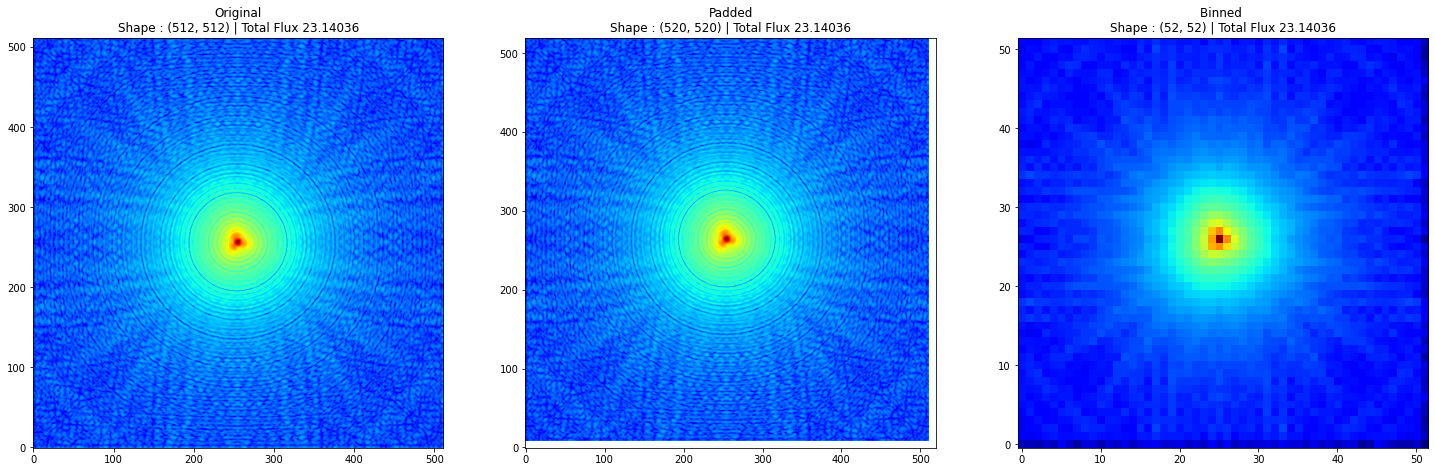

In [31]:
Flux = Off_PSF    #Off_PSF
Flux_p = np.pad(Flux,((8,0),(0,8)),mode='constant')
Flux_b = Flux_p.reshape(52,10, 52,10).sum(axis=3).sum(axis=1)

fig, ax = plt.subplots(1,3,figsize=(25,10))

ax[0].imshow(np.log10(Flux/Flux.max()),origin = 'lower',cmap='jet')
ax[0].set_title('Original\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux.shape,number=Flux.sum(), digits=5))

ax[1].imshow(np.log10(Flux_p/Flux_p.max()),origin = 'lower',cmap='jet')
ax[1].set_title('Padded\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_p.shape,number=Flux_p.sum(), digits=5))

ax[2].imshow(np.log10(Flux_b/Flux_b.max()),origin = 'lower',cmap='jet')
ax[2].set_title('Binned \nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_b.shape,number=Flux_b.sum(), digits=5));

In [47]:
Flux_b.sum(), Flux_b.max()

(23.140361890835003, 19.2196921)

In [46]:
dist, FWHM = fwhm_pixel_dist(Flux_b,r_frac=0.6)
FWHM

IndexError: ignored

In [ ]:
plt.plot(model(x))
plt.plot(out[:,25])

## **On-axis**

In [ ]:
Flux = On_PSF   
Flux_p = np.pad(Flux,((8,0),(0,8)),mode='constant')
Flux_b = Flux_p.reshape(52,10, 52,10).sum(axis=3).sum(axis=1)

fig, ax = plt.subplots(1,3,figsize=(25,10))

ax[0].imshow(np.log10(Flux/Flux.max()),origin = 'lower',cmap='jet')
ax[0].set_title('Original\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux.shape,number=Flux.sum(), digits=5))

ax[1].imshow(np.log10(Flux_p/Flux_p.max()),origin = 'lower',cmap='jet')
ax[1].set_title('Padded\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_p.shape,number=Flux_p.sum(), digits=5))

ax[2].imshow(np.log10(Flux_b/Flux_b.max()),origin = 'lower',cmap='jet')
ax[2].set_title('Binned \nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_b.shape,number=Flux_b.sum(), digits=5));

In [ ]:
from scipy.interpolate import interp1d, interp2d

In [ ]:
x  = np.linspace(-1.,1,52)
f = interp1d(x,Flux_b[:,25])

In [ ]:
plt.scatter(x,f(x))

In [ ]:
init  = models.Gaussian1D()
fit   = fitting.LevMarLSQFitter()
x     = np.linspace(-1,1,1024)
model = fit(init,x,f(x))
model

In [ ]:
2/1024

In [ ]:
(0.0193984/0.001953125)*gaussian_sigma_to_fwhm

In [ ]:
plt.scatter(x,f(x))
plt.scatter(x,model(x))
plt.legend(['PSF','Model'])

# **Ellitpical fitting**

In [ ]:
surf = np.loadtxt('nominal6.txt',skiprows=1)

with open('nominal6.txt','r') as f:
  columns = f.readline()[1:-1].split('\t')
  f.close()
df = pd.DataFrame(surf, columns = columns )

In [ ]:
df

In [ ]:
x = df['X-Field'].values
y = df['X-Field'].values
z = df['Sigma'].values

In [ ]:
xx,yy = np.meshgrid(x[:32],y[:32])

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
img = ax.scatter(xx,yy,c=z.reshape(32,32), marker="s", s = (1500./fig.dpi)**2,cmap='jet')
plt.colorbar(img)

In [ ]:
for deg in [3,4,5,6]:
  init = models.Polynomial2D(deg)

  fit = fitting.LevMarLSQFitter()

  model = fit(init,x=xx,y=yy,z=z.reshape(32,32))
  fig, ax = plt.subplots(1,3,figsize=(28,6))
  resid = model(xx,yy)-z.reshape(32,32)

  img0 = ax[0].scatter(xx,yy,c = z.reshape(32,32) , marker="s", s = (1500./fig.dpi)**2,cmap='jet')
  plt.colorbar(img0, ax=ax[0])
  ax[0].set_title('Data')

  img1 = ax[1].scatter(xx,yy,c = model(xx,yy), marker="s", s = (1500./fig.dpi)**2,cmap='jet')
  plt.colorbar(img1, ax=ax[1])
  ax[1].set_title(f'Model (Polynomial of Degree = {deg})')

  img2 = ax[2].scatter(xx,yy,c = resid, marker="s", s = (1500./fig.dpi)**2,cmap='jet')
  plt.colorbar(img2, ax=ax[2])
  ax[2].set_title('Residual | RMS : {:e}'.format(np.sqrt(np.mean(resid**2))))

  plt.show()